In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

In [3]:
import bnn.functions
import bnn.network
import bnn.layer
import bnn.loss
import bnn.optimizer

In [4]:
dims = [1, 10, 10, 4]
TBNN = bnn.network.TernBinNetwork(*dims)

In [5]:
TBNN._initialise(W_mean=0, W_zero_prob=1)

In [6]:
samples = 100
input = bnn.functions.binarise(torch.randn(samples, 1).to(torch.int))
desired = torch.stack(
    [input[..., 0], -input[..., 0], torch.ones(samples, dtype=torch.int), -torch.ones(samples, dtype=torch.int)],
    dim=-1
)
desired.shape

torch.Size([100, 4])

In [7]:
loss_func: bnn.loss.LossFunction = bnn.loss.l1

In [8]:
train_epochs = 100

In [9]:
BernOpt = bnn.optimizer.ExpectationSGD(TBNN.parameters(), lr=0.001)

In [10]:
losses = []
for epoch in range(train_epochs):
    # forward pass
    output = TBNN.forward(input)
    loss = loss_func.forward(output=output, target=desired)
    losses.append(loss)

    # backward pass
    grad = loss_func.backward(output=output, target=desired)
    out_grad = TBNN.backward(grad)

    # optimizer step
    BernOpt.step(number_of_samples=len(input))

    early_exit = loss == 0

    if early_exit or (epoch % 1) == 0:
        print(f"epoch: {epoch}\tloss: {loss}")

    if early_exit:
        break

epoch: 0	loss: 400
epoch: 1	loss: 96
epoch: 2	loss: 96
epoch: 3	loss: 200
epoch: 4	loss: 96
epoch: 5	loss: 96
epoch: 6	loss: 96
epoch: 7	loss: 200
epoch: 8	loss: 96
epoch: 9	loss: 96
epoch: 10	loss: 96
epoch: 11	loss: 96
epoch: 12	loss: 96
epoch: 13	loss: 48
epoch: 14	loss: 152
epoch: 15	loss: 200
epoch: 16	loss: 96
epoch: 17	loss: 48
epoch: 18	loss: 48
epoch: 19	loss: 48
epoch: 20	loss: 48
epoch: 21	loss: 0


In [11]:
TBNN.forward(-torch.ones(1, dtype=torch.int))

tensor([-1,  1,  1, -1], dtype=torch.int32)

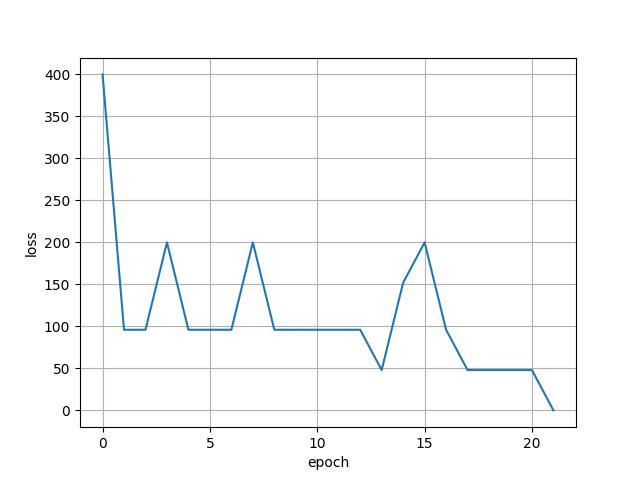

In [12]:
NAME = "loss_curve"
plt.close(NAME)
plt.figure(NAME)

plt.plot(losses)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()

plt.show()